# Baseline Model with Partial Sums
- Construct a baseline model with partial sums to compare against ScRRAMBLe.
- Refer to older scrips.

_Created on: 08/06/2025_

In [1]:
import jax
import math
import jax.numpy as jnp
import optax
import flax
from flax import nnx
from flax.nnx.nn import initializers
from typing import Callable
import json
import os
import pickle
import numpy as np
from collections import defaultdict
from functools import partial
from tqdm import tqdm
from datetime import date

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
# mpl.use('Agg')  # Use a non-interactive backend for matplotlib.

from models import ScRRAMBLeCapsLayer

from utils.activation_functions import quantized_relu_ste, squash, qrelu
# from utils.loss_functions import margin_loss
from utils import ScRRAMBLe_routing, intercore_connectivity, load_and_augment_mnist


import tensorflow_datasets as tfds  # TFDS to download MNIST.
import tensorflow as tf  # TensorFlow / `tf.data` operations.

%load_ext autoreload
%autoreload 2

2025-08-07 12:11:00.422730: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754593860.435790 2060556 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754593860.440006 2060556 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1754593860.451058 2060556 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1754593860.451070 2060556 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1754593860.451072 2060556 computation_placer.cc:177] computation placer alr

In [2]:
class PartialSumsLayer(nnx.Module):
    """
    Module for single partial sums layer.
    Takes in size of a feedforwardf layer.
    Initializes appropriate number of cores as trainable parameters.
    Accumulates partial sums across the cores
    """

    def __init__(self,
                 in_size: int,
                 out_size: int,
                 rngs: nnx.Rngs,
                 activation_function: Callable,
                 columns_per_core: int = 256
                 ):
        
        self.in_size = in_size
        self.out_size = out_size
        self.activation_function = activation_function
        self.columns_per_core = columns_per_core
        self.rngs = rngs

        # number of cores requires
        self.in_blocks = math.ceil(in_size / columns_per_core)
        self.out_blocks = math.ceil(out_size / columns_per_core)

        # initialize parameters
        initializer = initializers.glorot_normal()
        self.W = nnx.Param(
            initializer(self.rngs.params(), (self.out_blocks, self.in_blocks, self.columns_per_core, self.columns_per_core))
        )

    def __call__(self, x: jax.Array) -> jax.Array:
        """
        Forward pass. No batch dimension. use vmap
        Assume the x is flat
        """

        # # pad the input if in_size is not a multiple of 256
        # x_padded = jnp.pad(x, pad_width=((0, 0), (0, self.columns_per_core * self.in_blocks - self.in_size)))

        x_reshape = x.reshape(self.in_blocks, self.columns_per_core)

        # compute the partial sums
        y = jnp.einsum('ijkl,jl->ik', self.W, x_reshape)

        # apply activation function
        y = jax.vmap(self.activation_function, in_axes=(0,))(y)

        return y


In [3]:
# testing forward pass
rngs = nnx.Rngs(params=0, activations=1, permute=5, default=345)
x_test = jax.random.normal(rngs.default(), (10, 1024))
activation_function = nnx.relu
# activation_function = partial(qrelu, bits=4)
test_layer = PartialSumsLayer(
    in_size=x_test.shape[-1],
    out_size=512,
    rngs=rngs,
    activation_function=activation_function,
)

# nnx.display(test_layer)
y_test = jax.vmap(test_layer, in_axes=(0,))(x_test)
print(f"Output shape: {y_test.shape}")
print(f"Output: {y_test[0, 0, :10]}")

del test_layer

Output shape: (10, 2, 256)
Output: [0.         0.7686344  0.         0.         0.33890092 0.12463952
 0.         0.03248509 0.26785067 0.18344072]


In [3]:
# define a network with partial sums
class PartialSumsNetwork(nnx.Module):
    """
    Network with partial sums layers.
    """

    def __init__(self,
                 layer_sizes: list,
                 rngs: nnx.Rngs,
                 activation_function: Callable,
                 columns_per_core: int = 256
                ):
        
        self.layer_sizes = layer_sizes
        self.activation_function = activation_function
        self.columns_per_core = columns_per_core
        self.rngs = rngs

        # initialize the layers
        self.layers = [
            PartialSumsLayer(
                in_size=i,
                out_size=o,
                rngs=rngs,
                activation_function=activation_function,
                columns_per_core=columns_per_core
            )
            for i, o in zip(layer_sizes[:-1], layer_sizes[1:])
        ]

    def __call__(self, x: jax.Array) -> jax.Array:
        """
        Forward pass through the network. Assume that x has a batch dimension!
        """

        # resize the image to be (32, 32) for MNIST
        x = jax.image.resize(x, (x.shape[0], 32, 32, 1), method='nearest')

        # flatten the first two dimensions
        x = jnp.reshape(x, (x.shape[0], -1))

        for layer in self.layers:
            x = jax.vmap(layer, in_axes=(0,))(x)

        # at the final layer apply population code
        x = x.reshape(x.shape[0], -1)
        x = x[:, :250]
        x = x.reshape(x.shape[0], 10, -1)
        x = jnp.mean(x, axis=-1)

        return x

        

In [5]:
# testing the network
layer_sizes = [1024, 2048, 512, 256]
activation_function = nnx.relu
test_network = PartialSumsNetwork(
    layer_sizes=layer_sizes,
    rngs=rngs,
    activation_function=activation_function,
    columns_per_core=256
)

x_test = jax.random.normal(rngs.default(), (10, 32, 32, 1))
y_test = test_network(x_test)
print(f"Output shape: {y_test.shape}")
print(f"Output: {y_test[0, :]}")

# nnx.display(test_network)
del test_network  # Clean up the test network to free memory.

Output shape: (10, 10)
Output: [0.02932509 0.06052509 0.05852911 0.05839609 0.04864245 0.05797828
 0.05379442 0.01932956 0.04287183 0.08704461]


## Setting up a training pipeline

In [4]:
# dataset loading
data_dir = "/local_disk/vikrant/datasets"
dataset_dict = {
    'batch_size': 64, # 64 is a good batch size for MNIST
    'train_steps': int(2e4), # run for longer, 20000 is good!
    'binarize': True, 
    'greyscale': True,
    'data_dir': data_dir,
    'seed': 101,
    'shuffle_buffer': 1024,
    'threshold' : 0.5, # binarization threshold, not to be confused with the threshold in the model
    'eval_every': 1000,
}

# loading the dataset
train_ds, valid_ds, test_ds = load_and_augment_mnist(
    batch_size=dataset_dict['batch_size'],
    train_steps=dataset_dict['train_steps'],
    data_dir=dataset_dict['data_dir'],
    seed=dataset_dict['seed'],
    shuffle_buffer=dataset_dict['shuffle_buffer'],
)


W0000 00:00:1754593882.165226 2060556 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [5]:
# Training step functions
def loss_fn(model: PartialSumsNetwork, batch):
    logits = model(batch['image'])
    loss = optax.softmax_cross_entropy_with_integer_labels(
        logits=logits, labels=batch['label']
    ).mean()

    return loss, logits

@nnx.jit
@nnx.jit
def train_step(model: PartialSumsNetwork, optimizer: nnx.Optimizer, metrics: nnx.MultiMetric, batch, loss_fn: Callable = loss_fn):
  """Train for a single step."""
  grad_fn = nnx.value_and_grad(loss_fn, has_aux=True)
  (loss, logits), grads = grad_fn(model, batch)
  metrics.update(loss=loss, logits=logits, labels=batch['label'])  # In-place updates.
  optimizer.update(grads)  # In-place updates.

@nnx.jit
def eval_step(model: PartialSumsNetwork, metrics: nnx.MultiMetric, batch, loss_fn: Callable = loss_fn):
  loss, logits = loss_fn(model, batch)
  metrics.update(loss=loss, logits=logits, labels=batch['label'])  # In-place updates.

@nnx.jit
def pred_step(model: PartialSumsNetwork, batch):
  logits = model(batch['image'])
  return logits.argmax(axis=1)


In [6]:
key = jax.random.key(10)
key1, key2, key3, key4 = jax.random.split(key, 4)
rngs = nnx.Rngs(params=key1, activations=key2, permute=key3, default=key4)

# Initialize the model
model = PartialSumsNetwork(
    layer_sizes=[1024, 2048, 512, 256],
    rngs=rngs,
    activation_function=nnx.relu,
    columns_per_core=256
)

# optimizers
hyperparameters = {
    'learning_rate': 0.8e-4, # 1e-3 seems to work well
    'momentum': 0.9, 
    'weight_decay': 1e-4
}

optimizer = nnx.Optimizer(
    model,
    optax.adamw(learning_rate=hyperparameters['learning_rate'], weight_decay=hyperparameters['weight_decay'])
)

metrics = nnx.MultiMetric(
    accuracy=nnx.metrics.Accuracy(),
    loss=nnx.metrics.Average('loss')
)


In [7]:
metrics_history = {
'train_loss': [],
'train_accuracy': [],
'test_loss': [],
'valid_loss': [],
'valid_accuracy': [],
'test_accuracy': [],
'step': []
}

def train_scrramble_capsnet_mnist(
        model: PartialSumsNetwork = model,
        optimizer: nnx.Optimizer = optimizer,
        train_ds: tf.data.Dataset = train_ds,
        valid_ds: tf.data.Dataset = valid_ds,
        dataset_dict: dict = dataset_dict,
        save_model_flag: bool = False,
        save_metrics_flag: bool = False,
):
    
    eval_every = dataset_dict['eval_every']
    train_steps = dataset_dict['train_steps']

    for step, batch in enumerate(train_ds.as_numpy_iterator()):
        # Run the optimization for one step and make a stateful update to the following:
        # - The train state's model parameters
        # - The optimizer state
        # - The training loss and accuracy batch metrics

        train_step(model, optimizer, metrics, batch)

        if step > 0 and (step % eval_every == 0 or step == train_steps - 1):  # One training epoch has passed.
            metrics_history['step'].append(step)  # Record the step.
            # Log the training metrics.
            for metric, value in metrics.compute().items():  # Compute the metrics.
                metrics_history[f'train_{metric}'].append(float(value))  # Record the metrics.
            metrics.reset()  # Reset the metrics for the test set.

            # Compute the metrics on the validation set after each training epoch.
            for valid_batch in valid_ds.as_numpy_iterator():
                eval_step(model, metrics, valid_batch)

            # Log the validation metrics.
            for metric, value in metrics.compute().items():
                metrics_history[f'valid_{metric}'].append(float(value))
            metrics.reset()  # Reset the metrics for the next training epoch.

            print(f"Step {step}: Valid loss: {metrics_history['valid_loss'][-1]}, Accuracy: {metrics_history['valid_accuracy'][-1]}")

    best_accuracy = max(metrics_history['valid_accuracy'])
    print(f"Best accuracy: {best_accuracy}")

    # find the test set accuracy
    for test_batch in test_ds.as_numpy_iterator():
        eval_step(model, metrics, test_batch)
        # print the metrics
    for metric, value in metrics.compute().items():
        metrics_history[f'test_{metric}'].append(float(value))
    metrics.reset()  # Reset the metrics for the next training epoch.

    print("="*50)
    print(f"Test loss: {metrics_history['test_loss'][-1]}, Test accuracy: {metrics_history['test_accuracy'][-1]}")
    print("="*50)

    # if save_model_flag:
    #     today = date.today().isoformat()
    #     filename = f"sscamble_mnist_capsnet_recon_capsules{(sum(model.layer_sizes)-model.input_eff_capsules):d}_acc_{metrics_history['test_accuracy'][-1]*100:.0f}_{today}.pkl"
    #     graphdef, state = nnx.split(model)
    #     save_model(state, filename)

    # if save_metrics_flag:
    #     today = date.today().isoformat()
    #     filename = f"sscamble_mnist_capsnet_recon_capsules{(sum(model.layer_sizes)-model.input_eff_capsules):d}_acc_{metrics_history['test_accuracy'][-1]*100:.0f}_{today}.pkl"
    #     save_metrics(metrics_history, filename)

    return model


In [8]:
trained_model = train_scrramble_capsnet_mnist(
    model=model,
    optimizer=optimizer,
    train_ds=train_ds,
    valid_ds=valid_ds,
    dataset_dict=dataset_dict,
    save_model_flag=False,  # Set to True if you want to save the model.
    save_metrics_flag=False,  # Set to True if you want to save the metrics.
)

2025-08-07 12:11:26.799395: W external/xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this by using the full hints set instead.
2025-08-07 12:11:26.799425: W external/xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this by using the full hints set instead.
2025-08-07 12:11:26.799485: W external/xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this by using the full hints set instead.
2025-08-07 12:11:26.799497: W external/xla/xla/service/gpu/au

Step 1000: Valid loss: 0.5657087564468384, Accuracy: 0.8353873491287231
Step 2000: Valid loss: 0.32924798130989075, Accuracy: 0.9022687673568726
Step 3000: Valid loss: 0.23673319816589355, Accuracy: 0.9334587454795837
Step 4000: Valid loss: 0.19923493266105652, Accuracy: 0.9414412975311279
Step 5000: Valid loss: 0.17936347424983978, Accuracy: 0.948203444480896
Step 6000: Valid loss: 0.15938761830329895, Accuracy: 0.9532450437545776
Step 7000: Valid loss: 0.1526576280593872, Accuracy: 0.9547855257987976
Step 8000: Valid loss: 0.13630181550979614, Accuracy: 0.9591269493103027
Step 9000: Valid loss: 0.125034362077713, Accuracy: 0.9633883237838745
Step 10000: Valid loss: 0.1245848685503006, Accuracy: 0.9628481268882751
Step 11000: Valid loss: 0.10779351741075516, Accuracy: 0.967869758605957
Step 12000: Valid loss: 0.11494171619415283, Accuracy: 0.9657090306282043
Step 13000: Valid loss: 0.1094745323061943, Accuracy: 0.9675295948982239
Step 14000: Valid loss: 0.0988001599907875, Accuracy: 0

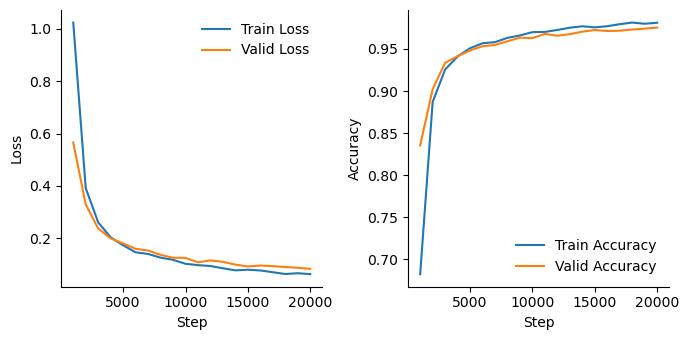

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(7, 3.5))
# Plot training and validation loss
ax[0].plot(metrics_history['step'], metrics_history['train_loss'], label='Train Loss')
ax[0].plot(metrics_history['step'], metrics_history['valid_loss'], label='Valid Loss')
ax[0].set_xlabel('Step')
ax[0].set_ylabel('Loss')
ax[0].legend(frameon=False)

ax[1].plot(metrics_history['step'], metrics_history['train_accuracy'], label='Train Accuracy')
ax[1].plot(metrics_history['step'], metrics_history['valid_accuracy'], label='Valid Accuracy')
ax[1].set_xlabel('Step')
ax[1].set_ylabel('Accuracy')
ax[1].legend(frameon=False)

plt.tight_layout()
sns.despine(top=True, right=True)

In [11]:
del model

## Preliminary plots for performance with quantization

In [14]:
graphdef, trained_state = nnx.split(trained_model)

# create a loop to iterate over bit resolution, keep the dynamic range at 3db
res_list = jnp.arange(1, 33, 1).tolist()
accuracy_per_res = []

for res in tqdm(res_list, total=len(res_list), desc="Quantizing models"):
    print(f"Quantizing with {res} bits resolution...")

    qmodel = PartialSumsNetwork(
        layer_sizes=[1024, 2048, 512, 256],
        rngs=nnx.Rngs(params=0, activations=1, permute=5, default=345),
        activation_function=partial(qrelu, bits=res, max_value=2.0),
        columns_per_core=256
    )

    qgraphdef, _ = nnx.split(qmodel)
    qmodel = nnx.merge(qgraphdef, trained_state)

    qmodel.eval() # Switch to evaluation mode.

    accuracies = []

    # evaluate the quantized model
    for test_batch in test_ds.as_numpy_iterator():
        preds = pred_step(qmodel, test_batch)
        true_labels = test_batch['label']
        accuracies.append(jnp.mean(preds == true_labels))

    accuracy = jnp.mean(jnp.array(accuracies))
    accuracy_per_res.append(float(accuracy))
    print(f"Accuracy: {accuracy:.4f}, resolution: {res} bits")

Quantizing models:   0%|          | 0/32 [00:00<?, ?it/s]2025-08-07 12:30:52.062771: W external/xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this by using the full hints set instead.


Quantizing with 1 bits resolution...


Quantizing models:   3%|▎         | 1/32 [00:01<00:39,  1.28s/it]

Accuracy: 0.0980, resolution: 1 bits
Quantizing with 2 bits resolution...


Quantizing models:   6%|▋         | 2/32 [00:01<00:27,  1.10it/s]

Accuracy: 0.6596, resolution: 2 bits
Quantizing with 3 bits resolution...


Quantizing models:   9%|▉         | 3/32 [00:02<00:22,  1.27it/s]

Accuracy: 0.6469, resolution: 3 bits
Quantizing with 4 bits resolution...


Quantizing models:  12%|█▎        | 4/32 [00:03<00:20,  1.36it/s]

Accuracy: 0.6769, resolution: 4 bits
Quantizing with 5 bits resolution...


Quantizing models:  16%|█▌        | 5/32 [00:03<00:18,  1.42it/s]

Accuracy: 0.6912, resolution: 5 bits
Quantizing with 6 bits resolution...


Quantizing models:  19%|█▉        | 6/32 [00:04<00:17,  1.47it/s]

Accuracy: 0.6973, resolution: 6 bits
Quantizing with 7 bits resolution...


Quantizing models:  22%|██▏       | 7/32 [00:05<00:16,  1.49it/s]

Accuracy: 0.7003, resolution: 7 bits
Quantizing with 8 bits resolution...


Quantizing models:  25%|██▌       | 8/32 [00:05<00:16,  1.49it/s]

Accuracy: 0.7020, resolution: 8 bits
Quantizing with 9 bits resolution...


Quantizing models:  28%|██▊       | 9/32 [00:06<00:15,  1.51it/s]

Accuracy: 0.7032, resolution: 9 bits
Quantizing with 10 bits resolution...


Quantizing models:  31%|███▏      | 10/32 [00:07<00:14,  1.52it/s]

Accuracy: 0.7039, resolution: 10 bits
Quantizing with 11 bits resolution...


Quantizing models:  34%|███▍      | 11/32 [00:07<00:13,  1.52it/s]

Accuracy: 0.7040, resolution: 11 bits
Quantizing with 12 bits resolution...


Quantizing models:  38%|███▊      | 12/32 [00:08<00:13,  1.52it/s]

Accuracy: 0.7040, resolution: 12 bits
Quantizing with 13 bits resolution...


Quantizing models:  41%|████      | 13/32 [00:09<00:12,  1.52it/s]

Accuracy: 0.7041, resolution: 13 bits
Quantizing with 14 bits resolution...


Quantizing models:  44%|████▍     | 14/32 [00:09<00:11,  1.52it/s]

Accuracy: 0.7041, resolution: 14 bits
Quantizing with 15 bits resolution...


Quantizing models:  47%|████▋     | 15/32 [00:10<00:11,  1.52it/s]

Accuracy: 0.7041, resolution: 15 bits
Quantizing with 16 bits resolution...


Quantizing models:  50%|█████     | 16/32 [00:11<00:10,  1.53it/s]

Accuracy: 0.7042, resolution: 16 bits
Quantizing with 17 bits resolution...


Quantizing models:  53%|█████▎    | 17/32 [00:11<00:09,  1.52it/s]

Accuracy: 0.7042, resolution: 17 bits
Quantizing with 18 bits resolution...


Quantizing models:  56%|█████▋    | 18/32 [00:12<00:09,  1.52it/s]

Accuracy: 0.7042, resolution: 18 bits
Quantizing with 19 bits resolution...


Quantizing models:  59%|█████▉    | 19/32 [00:13<00:08,  1.53it/s]

Accuracy: 0.7042, resolution: 19 bits
Quantizing with 20 bits resolution...


Quantizing models:  62%|██████▎   | 20/32 [00:13<00:07,  1.52it/s]

Accuracy: 0.7042, resolution: 20 bits
Quantizing with 21 bits resolution...


Quantizing models:  66%|██████▌   | 21/32 [00:14<00:07,  1.51it/s]

Accuracy: 0.7042, resolution: 21 bits
Quantizing with 22 bits resolution...


Quantizing models:  69%|██████▉   | 22/32 [00:15<00:06,  1.50it/s]

Accuracy: 0.7042, resolution: 22 bits
Quantizing with 23 bits resolution...


Quantizing models:  72%|███████▏  | 23/32 [00:15<00:06,  1.50it/s]

Accuracy: 0.7042, resolution: 23 bits
Quantizing with 24 bits resolution...


Quantizing models:  75%|███████▌  | 24/32 [00:16<00:05,  1.50it/s]

Accuracy: 0.7042, resolution: 24 bits
Quantizing with 25 bits resolution...


Quantizing models:  78%|███████▊  | 25/32 [00:17<00:04,  1.50it/s]

Accuracy: 0.7042, resolution: 25 bits
Quantizing with 26 bits resolution...


Quantizing models:  81%|████████▏ | 26/32 [00:17<00:03,  1.51it/s]

Accuracy: 0.7042, resolution: 26 bits
Quantizing with 27 bits resolution...


Quantizing models:  84%|████████▍ | 27/32 [00:18<00:03,  1.51it/s]

Accuracy: 0.7042, resolution: 27 bits
Quantizing with 28 bits resolution...


Quantizing models:  88%|████████▊ | 28/32 [00:19<00:02,  1.50it/s]

Accuracy: 0.7042, resolution: 28 bits
Quantizing with 29 bits resolution...


Quantizing models:  91%|█████████ | 29/32 [00:19<00:01,  1.51it/s]

Accuracy: 0.7042, resolution: 29 bits
Quantizing with 30 bits resolution...


Quantizing models:  94%|█████████▍| 30/32 [00:20<00:01,  1.52it/s]

Accuracy: 0.7042, resolution: 30 bits
Quantizing with 31 bits resolution...


Quantizing models:  97%|█████████▋| 31/32 [00:21<00:00,  1.52it/s]

Accuracy: 0.7042, resolution: 31 bits
Quantizing with 32 bits resolution...


Quantizing models: 100%|██████████| 32/32 [00:21<00:00,  1.48it/s]

Accuracy: 0.7042, resolution: 32 bits


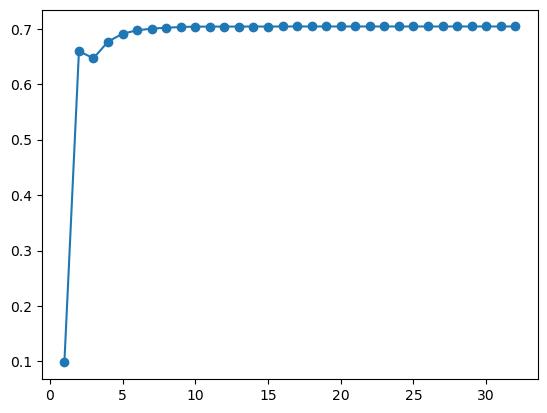

In [15]:
plt.plot(res_list, accuracy_per_res, marker='o')